In [109]:
import sys, os
import xarray as xr
import numpy as np
import biometeo
from dask.diagnostics import ProgressBar

from mrt_utils import *

from tqdm import tqdm

import importlib
import biometeo_parallel
from multiprocessing import cpu_count


In [ ]:
ground_alb  = 0.2
ground_emis = 0.95
ground_z0 = 0.1

exp_name = 'OUT_v6teb_ICONfixed2ERA5_AEV5t2_alb2_rt25_noconv_rucpOVMr2_thDS'

if os.name == 'nt':
    ds_dir = fr"G:\!Data\Moscow\CLM\Experiments\Short_runs_MSK\20210601\MSK_0.0025_WorldCover1_rucpOVMr2\{exp_name}\cr\\"
else:
    ds_dir = f'/home/mvarentsov/data/COSMO/MSK/20210601/MSK_0.0025_WorldCover1_rucpOVMr2/{exp_name}/cr/'

ds = xr.open_mfdataset(ds_dir + '*.nc')
ds.load()

ds['VEL_10M'] = np.sqrt (ds['U_10M']**2 + ds['V_10M']**2)
ds['GHI'] = ds['SWDIRS_RAD'] + ds['SWDIFDS_RAD']

In [84]:
if 'MRT_sun' not in ds.data_vars or 'MRT_shd' not in ds.data_vars:
    ds['MRT_sun'],ds['MRT_shd'] = calc_MRT4ds (ds, 'T_2M', 'GHI', 'SWDIFDS_RAD', 'THDS_RAD', 'T_G', ground_alb, ground_emis)
    ds['MRT_sun'].to_netcdf(ds_dir + 'MRT_sun.nc')
    ds['MRT_shd'].to_netcdf(ds_dir + 'MRT_shd.nc')


ds['T_2Mc'] = ds['T_2M'] - 273.15
ds['E_2M'] = 6.11 * np.exp(17.27 * ds['T_2Mc'] / (ds['T_2Mc'] + 237.3))
ds['e_2M'] = ds['E_2M'] * ds['RELHUM_2M'] / 100

# Compute wind speed at 1.1m with bounds
ds['VEL_1.1m'] = ds['VEL_10M'] * np.log(1.1/ground_z0) / np.log(10/ground_z0)
ds['VEL_1.1m'] = ds['VEL_1.1m'].clip(min=0.341, max=11.5)

# Convert MRT to Celsius
ds['MRT_sun_C'] = ds['MRT_sun'] - 273.15
ds['MRT_shd_C'] = ds['MRT_shd'] - 273.15

In [99]:

importlib.reload(biometeo_parallel)

ds_sel = ds.isel(rlon=slice(0,30), rlat=slice(0,30))

n_jobs = 8

ds_sel['PET_sun']  = biometeo_parallel.compute4xarray_ds (biometeo.PET, ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, result_key='PET_v', n_chunks=361, use_tqdm = True)
ds_sel['PET_shd']  = biometeo_parallel.compute4xarray_ds (biometeo.PET, ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, result_key='PET_v', n_chunks=361, use_tqdm = True)
ds_sel['UTCI_sun'] = biometeo_parallel.compute4xarray_ds (biometeo.UTCI, ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, n_chunks=361, use_tqdm = True)
ds_sel['UTCI_shd'] = biometeo_parallel.compute4xarray_ds (biometeo.UTCI, ds_sel, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, n_chunks=361, use_tqdm = True)

# ds_sel['PET_sun'] = ds_sel['T_2M'] * np.nan
# ds_sel['PET_shd'] = ds_sel['T_2M'] * np.nan
# ds_sel['UTCI_sun'] = ds_sel['T_2M'] * np.nan
# ds_sel['UTCI_shd'] = ds_sel['T_2M'] * np.nan

# for i,time in tqdm (enumerate(ds.time), total=ds_sel.time.shape[0]):

#     ds4time = ds_sel.isel(time=i)

#     ds_sel['PET_sun'][i,:,:] = biometeo_parallel.compute4xarray_ds (biometeo.PET, ds4time, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, result_key='PET_v', n_chunks=100, use_tqdm = False)
#     ds_sel['PET_shd'][i,:,:] = biometeo_parallel.compute4xarray_ds (biometeo.PET, ds4time, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, result_key='PET_v', n_chunks=100, use_tqdm = False)
#     ds_sel['UTCI_sun'][i,:,:] = biometeo_parallel.compute4xarray_ds (biometeo.UTCI, ds4time, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_sun_C'}, n_jobs, n_chunks=100, use_tqdm = False)
#     ds_sel['UTCI_shd'][i,:,:] = biometeo_parallel.compute4xarray_ds (biometeo.UTCI, ds4time, {'Ta':'T_2Mc', 'v':'VEL_1.1m', 'VP':'e_2M', 'Tmrt':'MRT_shd_C'}, n_jobs, n_chunks=100, use_tqdm = False)

100%|██████████| 361/361 [00:12<00:00, 30.05it/s]


In [ ]:
ds_sel['PET_sun'].to_netcdf(ds_dir + 'PET_sun.nc')
ds_sel['PET_shd'].to_netcdf(ds_dir + 'PET_shd.nc')
ds_sel['UTCI_sun'].to_netcdf(ds_dir + 'UTCI_sun.nc')
ds_sel['UTCI_shd'].to_netcdf(ds_dir + 'UTCI_shd.nc')

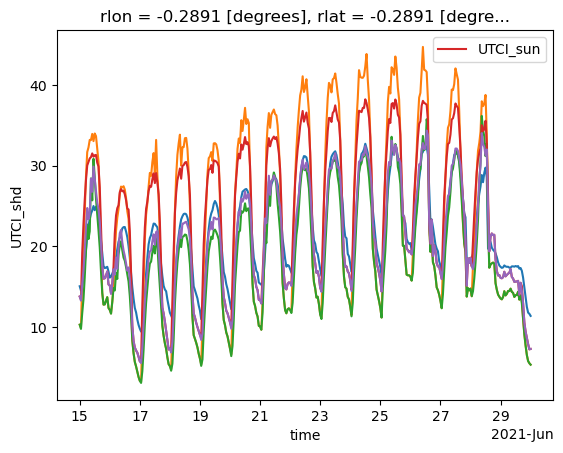

In [104]:
from matplotlib import pyplot as plt

ds4point = ds_sel.isel(rlon=4, rlat=4)
(ds4point['T_2M']-273.5).plot()
ds4point['PET_sun'].plot()
ds4point['PET_shd'].plot()

ds4point['UTCI_sun'].plot(label='UTCI_sun')
ds4point['UTCI_shd'].plot()

plt.legend()